# PDE megoldó FiPy csomaggal


A következő package-ek szükségesek:
- future
- fipy
- numpy
- matplotlib
- scipy

A megoldandó differenciálegyenlet általános alakja:

$$ \frac{\partial n(r,t)}{\partial t}=D\frac{\partial^2 n(r,t)}{\partial r^2}-K\frac{\partial n(r,t)}{\partial r}+S(r,t) $$

### Importálások és saját függvények

A Dirac-delta függvény visszaadja a következőt: ahol
$$ x<\varepsilon\quad\text{és}\quad x>-\varepsilon \text{,}$$
ott:
$$ \frac{(1+\cos(\frac{\pi x}{\varepsilon}))\cdot\varepsilon}{2} $$

In [2]:
import fipy as fp
from fipy.tools import numerix  # FiPy-al használatos, gyakorlatilag numpy
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Dirac delta függvény numerikus implementálása
def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon))) / 2 / epsilon

div
4
power
[-33 -29 -25 -21 -17 -13  -9  -5  -1]
ticks
[1.e-33 1.e-29 1.e-25 1.e-21 1.e-17 1.e-13 1.e-09 1.e-05 1.e-01]


Text(0.5, 1.0, 'Elfutó elektronok sűrűsége (1/m^3)')

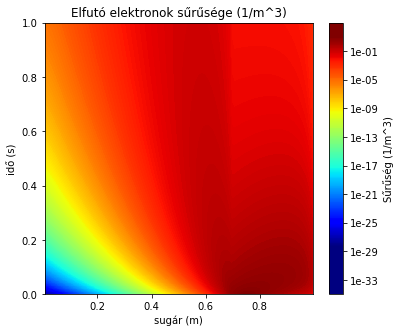

In [41]:
# Dirac delta a kezdeti feltételben, diffúzió és konvekció
# Bal oldalt 0. Neumann határfeltétel, jobb oldalt 0. Dirichlet határfeltétel
# Sugár felénél Dirac-delta kezdeti feltétel
# Újrainicializáláshoz a TEMPLATE alatti részt kell másolni

## TEMPLATE ##

R = 1.  ## teljes sugár
nr = 100  ## ennyi cellára lesz felosztva a tartomány
dr = R / nr  ## távolság a cellák közepei között
duration = 1.  ## teljes szimulációs időtartam
nt = 100  ## időosztások száma
dt = duration / nt  ## időlépés
radius = np.zeros(nr)

## 3D array az eredmények tárolására - nt*nr távolság-sűrűség értékpár
solution = np.zeros((nt,nr,2))  
## távolságértékek betöltése
for j in range(nr):
    solution[:,j,0] = j * dr + dr / 2
    radius[j] =  j * dr + dr / 2

mesh = fp.Grid1D(dx=dr, nx=nr)  ## mesh az 1D sugármenti változóhoz
n = fp.CellVariable(mesh=mesh)  ## egyes időpillanatokban a sűrűség a sugár mentén

diracLoc = 0.75 ## Dirac-delta helyzete
diracCoeff = 1.  ## Dirac-delta együtthatója (nagysága)

cC = (numerix.sin(mesh.x)) * 2
diffCoeff = fp.CellVariable(mesh=mesh, value=0.01 * numerix.cos(mesh.x) ** 2 + 0.1)  ## diffúziós eh
convCoeff = fp.CellVariable(mesh=mesh, value=[cC])  ## konvekciós együttható <<<<<<<<<<<<<<<<<<<<<<<

#határfeltételek
gradLeft = (0.,)  ## bal oldali gradiens
valueRight = 0.  ## jobb oldali sűrűségérték
n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## Neumann határfeltétel érvényesítése
n.constrain(valueRight, mesh.facesRight)  ## Dirichlet határfeltétel érvényesítése
convCoeff.setValue(0, where=mesh.x<0.7)  ## konvekciós eh. 0 a belső felületen
diffCoeff.setValue(0.01, where=mesh.x<0.7)  ## diffúziós eh. kicsi belül

#kezdeti feltételek
n.setValue(delta_func(mesh.x - diracLoc, 4 * dr, diracCoeff))

## Az egyenlet intuitív elnevezésekkel
eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
      - fp.ConvectionTerm(coeff=convCoeff))

## Tér- és időfüggő adatbetöltés a 3D változóba
for i in range(nt):
    eq.solve(var=n, dt=dt)  ## minden időlépésben megoldás
    #n_log = copy.deepcopy(np.log(n.value))
    solution[i,0:nr,1]=copy.deepcopy(n.value)

################################################################################################
## ábrázolás
sol_min = solution[:,:,1].min()
sol_max = solution[:,:,1].max()
num_of_lvls = 300  ## ennyi különböző színnel lesz ábrázolva
logmin = int(np.log(sol_min)) + 30
logmax = int(np.log(sol_max)) + 1
logdiff = logmax - logmin
numofticks = 9
div = logdiff // numofticks
power = np.arange((logmax - (numofticks * div)), logmax, div)
array1 = np.zeros(len(power)) + 10.
ticks = np.power(array1, power)
print('div')
print(div)
print('power')
print(power)
print('ticks')
print(ticks)

levels = np.logspace(logmin,logmax,num_of_lvls)
norm = matplotlib.colors.LogNorm(vmin=sol_min,vmax=sol_max)
formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)

fig = plt.figure(figsize=(6,5))
plot = plt.contourf(radius, np.linspace(0.,duration,nt), solution[:,:,1],
                    levels=levels, norm=norm, cmap=plt.cm.jet)
axes = plt.gca()
axes.axis('tight')
axes.set_aspect('equal', 'datalim')
#axes.set_xlim([0.6,1])
#axes.set_ylim([0.,1.])
#axes.set_yscale('log')
cbar = plt.colorbar(ticks=ticks, format=formatter)
cbar.set_label("Sűrűség (1/m^3)")
plt.xlabel('sugár (m)')
plt.ylabel('idő (s)')
plt.title('Elfutó elektronok sűrűsége (1/m^3)')